In [1]:
import os
import sys
import argparse
import pandas as pd
import torch
import anndata as ad
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from DeepRUOT.losses import OT_loss1
from DeepRUOT.utils import (
    generate_steps, load_and_merge_config,
    SchrodingerBridgeConditionalFlowMatcher,
    generate_state_trajectory, get_batch, get_batch_size
)
from DeepRUOT.train import train_un1_reduce, train_all
from DeepRUOT.models import FNet, scoreNet2
from DeepRUOT.constants import DATA_DIR, RES_DIR
from DeepRUOT.exp import setup_exp

### Load config

In [2]:
config_path = '../config/elegan_config.yaml'

# Load and merge configuration
config = load_and_merge_config(config_path)

### Load data and model

In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, config['data']['file_path']))

#df = pd.read_csv('D:\DeepRUOTv2\data\elegan_pca.csv')
df = df.iloc[:, :config['data']['dim'] + 1]
device = torch.device('cpu')
exp_dir, logger = setup_exp(
            RES_DIR, 
            config, 
            config['exp']['name']
        )
dim = config['data']['dim']

In [4]:
model_config = config['model']
        
f_net = FNet(
    in_out_dim=model_config['in_out_dim'],
    hidden_dim=model_config['hidden_dim'],
    n_hiddens=model_config['n_hiddens'],
    activation=model_config['activation']
).to(device)

sf2m_score_model = scoreNet2(
    in_out_dim=model_config['in_out_dim'],
    hidden_dim=model_config['score_hidden_dim'],
    activation=model_config['activation']
).float().to(device)

In [5]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir, 'model_result'),map_location=torch.device('cpu')))
f_net.to(device)
sf2m_score_model.load_state_dict(torch.load(os.path.join(exp_dir, 'score_model'),map_location=torch.device('cpu')))
sf2m_score_model.to(device)

scoreNet2(
  (activation): LeakyReLU(negative_slope=0.01)
  (net): Sequential(
    (0): Linear(in_features=51, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

### Dim reduction (Optional)

In [16]:
import numpy as np
import joblib
from sklearn.decomposition import PCA  # Import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import umap
umap_op = umap.UMAP(n_components=2, random_state=42) # You may change UMAP to PCA or other dimension reduction methods
xu = umap_op.fit_transform(df.iloc[:, 1:])  # Assuming df is your DataFrame
joblib.dump(umap_op, os.path.join(exp_dir, 'dim_reduction.pkl'))  # Save the UMAP model

['d:\\DeepRUOTv2\\results\\elegan_experiment_reverse\\dim_reduction.pkl']

### Plot Growth

In [9]:
import scanpy as sc
adata = sc.read_h5ad("D:\DeepRUOTv2\data\c_elegans_prep.h5ad")
keep_mask = adata.obs["lineage"].str.startswith("ABpxp")
adata = adata[keep_mask].copy()


adata.obsm['X_umap_abpxp'].shape

(7356, 2)

[]

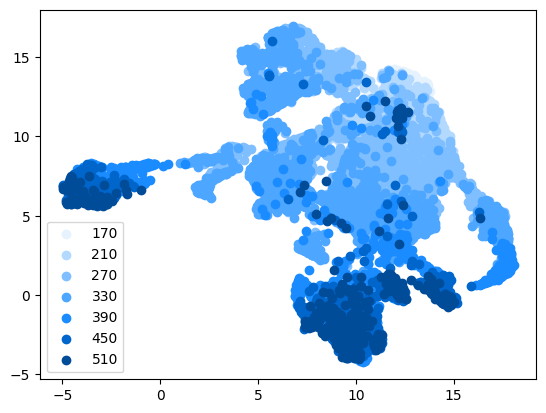

In [16]:
import matplotlib.pyplot as plt
time_points = [170, 210, 270, 330, 390, 450, 510]
color_map = ['#e6f3ff', '#b3d9ff', '#80bfff', '#4da6ff', '#1a8cff', '#0066cc', '#004c99']
for i,time_point in enumerate(time_points):
    adata_subset = adata[adata.obs['time_assigned'] == time_point]
    # Add time_point column to PCA data
    plt.scatter(adata_subset.obsm['X_umap_abpxp'][:,0], adata_subset.obsm['X_umap_abpxp'][:,1], color = color_map[i], label = time_point)
plt.legend()
plt.plot()

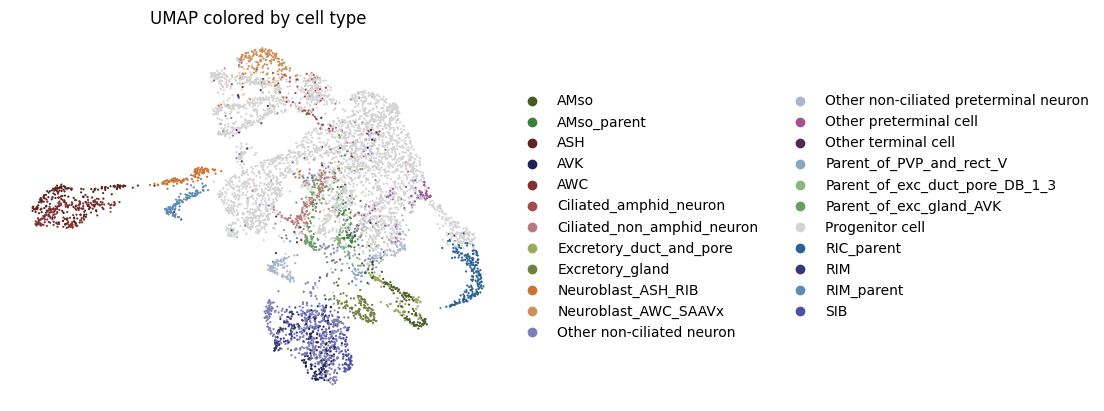

In [18]:
# Plot cells colored by cell type using scanpy
sc.pl.embedding(adata, 
                basis='umap_abpxp',
                color='clusters',
                size=10,
                title='UMAP colored by cell type',
                frameon=False)


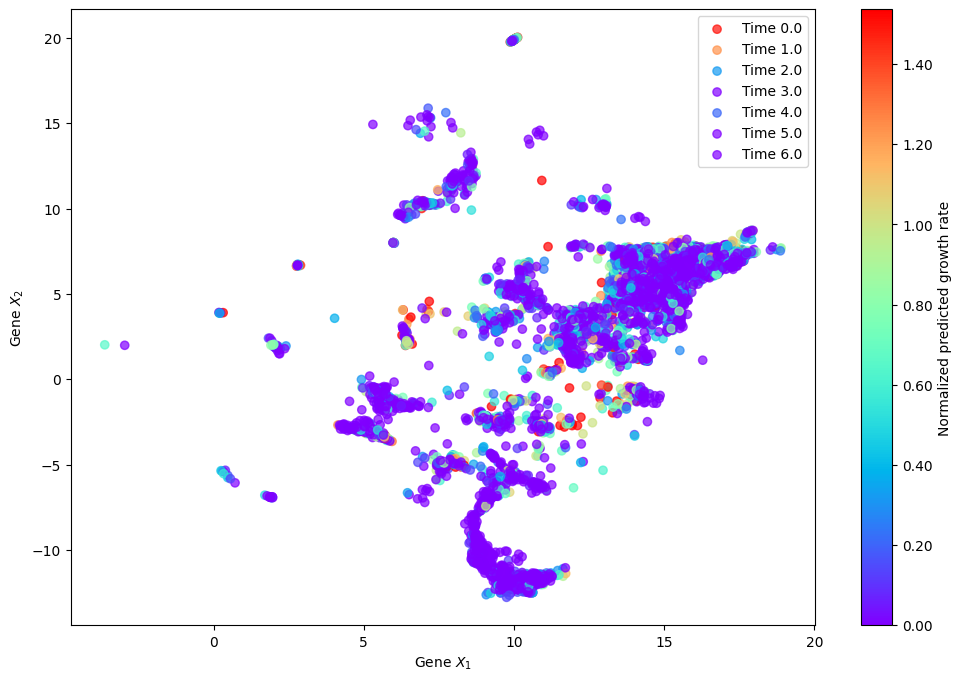

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import joblib

# Load dimension reducer
dim_reducer = joblib.load(os.path.join(exp_dir, 'dim_reduction.pkl')) # If no dim reducer is needed, set this to None
device = 'cpu'
f_net = f_net.to(device)

def plot_g_values(df, f_net, dim_reducer=None, device=device):
    # Get all time points
    time_points = df['samples'].unique()
    
    # Store data for each time point
    data_by_time = {}
    
    # Calculate g_values for each time point
    for time in time_points:
        subset = df[df['samples'] == time]
        n = dim  # Make sure dim is defined

        # Generate column names
        column_names = [f'x{i}' for i in range(1, n + 1)]

        # Convert each column to tensor and move to device
        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        # Stack tensors into 2D tensor
        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g, _, _ = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    # Combine all g_values
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    # Calculate 95th percentile of g_values
    vmax_value = np.percentile(all_g_values, 95)
    
    # Initialize color mapper with clipping
    norm = plt.Normalize(vmin=0, vmax=vmax_value, clip=True)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot data for each time point on same axis
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        n = dim

        column_names = [f'x{i}' for i in range(1, n + 1)]
        new_data = subset[column_names]
        
        if dim_reducer is not None:
            data_reduced = dim_reducer.transform(new_data)
        else:
            data_reduced = new_data.iloc[:, :2].values
            
        x = data_reduced[:, 0]
        y = data_reduced[:, 1]
        
        # Map g_values to colors
        colors = plt.cm.rainbow(norm(g_values))
        
        # Plot scatter with labels for legend
        ax.scatter(x, y, c=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    ax.legend()
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    # Format colorbar ticks
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{(x):.2f}'))
    
    # Save as PDF
    plt.savefig(os.path.join(exp_dir, 'g_values_plot.pdf'), format='pdf', bbox_inches='tight')
    
    plt.show()

# Plot with f_net and df
plot_g_values(df, f_net, dim_reducer=dim_reducer)

### Plot Velocity

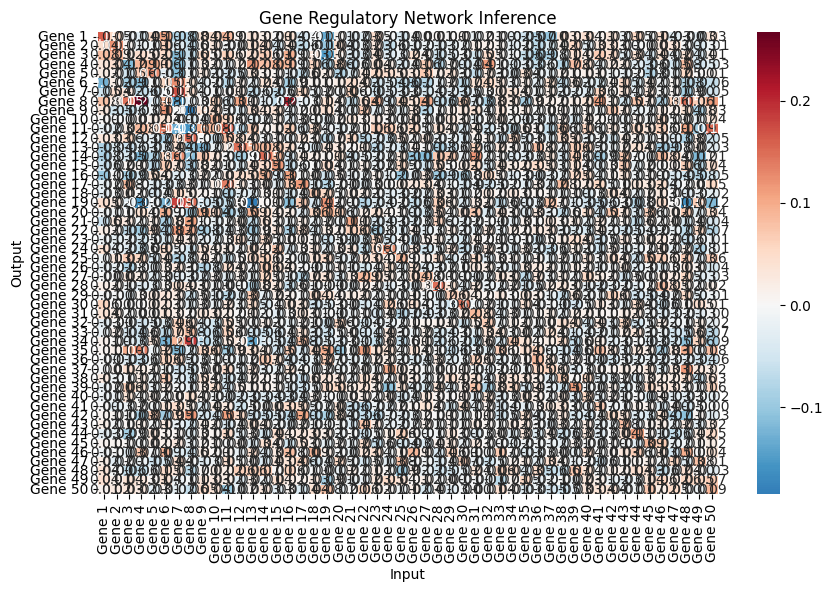

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
# Assume the following are defined:
# - df: DataFrame with columns 'samples', 'x1', 'x2', ..., 'xn'
# - dim: Number of dimensions (n)
# - device: torch.device (e.g., 'cpu' or 'cpu')
# - sf2m_score_model: Your model function that takes t_tensor and data_tensor

# Step 1: Extract all time points and data points


all_times = df['samples'].values
all_data = df[[f'x{i}' for i in range(1, dim + 1)]].values

#t_value = 2.0  
t_tensor = torch.tensor(all_times).unsqueeze(1).float().to(device)

# Step 2: Convert to PyTorch tensors
data_tensor = torch.tensor(all_data, dtype=torch.float32).to(device)
data_tensor.requires_grad_(True)  # Enable gradient tracking
#t_tensor = torch.tensor(all_times, dtype=torch.float32).unsqueeze(1).to(device)

lnw0 = torch.log(torch.ones(data_tensor.shape[0], 1) / data_tensor.shape[0]).to(device)
# Step 3: Compute log density values and gradients
gradients = f_net.v_net(t_tensor, data_tensor)

import seaborn as sns

# Calculate Jacobian matrix for v_net including time derivatives
def compute_jacobian_with_time(x, t, v_net):
    batch_size = x.shape[0]
    n_dims = x.shape[1]
    # Include time dimension in Jacobian
    jacobian = torch.zeros(batch_size, n_dims, n_dims).to(x.device)
    
    for i in range(n_dims):
        t.requires_grad_(True)
        x.requires_grad_(True)
        # Calculate spatial gradients
        v = v_net(t, x)[:, i]
        grads = torch.autograd.grad(v.sum(), x, create_graph=True, retain_graph=True)[0]
        jacobian[:, i, :n_dims] = grads  # Keep original gradients without negation
        

    return jacobian

# Compute Jacobian for each point at t=0
t0_mask = (t_tensor == 1).squeeze()

#data_mask = (data_tensor[:,0] > 0.5).squeeze()
t0_data = data_tensor[t0_mask]
t0_times = t_tensor[t0_mask]

jacobians = compute_jacobian_with_time(t0_data, t0_times, f_net.v_net)
#jacobians = compute_jacobian_with_time(data_tensor, t_tensor, f_net.v_net)

# Average Jacobian across all points
avg_jacobian = jacobians.mean(dim=0).detach().cpu().numpy()

# Create heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(avg_jacobian,
            annot=True,
            cmap='RdBu_r', 
            center=0,
            fmt='.2f',
            xticklabels=[f'Gene {i+1}' for i in range(dim)],
            yticklabels=[f'Gene {i+1}' for i in range(dim)])
plt.title('Gene Regulatory Network Inference')
plt.xlabel('Input')
plt.ylabel('Output')

# Save plot
#plt.savefig(os.path.join(exp_dir, 'regulatory_network.pdf'), format='pdf', bbox_inches='tight')
plt.show()


# Step 4: Move data to CPU for plotting
data_np = data_tensor.detach().cpu().numpy()
if dim_reducer is not None:
    data_np_2d=dim_reducer.transform(data_np)
else:
    data_np_2d=data_np[:,:2]
gradients_np = gradients.detach().cpu().numpy()
data_end = data_np + gradients_np
if dim_reducer is not None:
    data_end_2d=dim_reducer.transform(data_end)
else:
    data_end_2d=data_end[:,:2]
gradients_np=data_end_2d - data_np_2d

gradients_np = gradients_np / np.linalg.norm(gradients_np, axis = 1, keepdims=True) * 5
times_np = all_times
data_np = data_np_2d

In [9]:
import anndata
import scvelo as scv
import scanpy as sc
import numpy as np

# Assume your data is already defined
# all_data: 50-dimensional data with shape (n_cells, 50)
# gradients: 50-dimensional vector field with shape (n_cells, 50) 
# pca: Trained PCA or UMAP model for generating X_umap
# X_umap: Pre-computed UMAP embeddings with shape (n_cells, 2)

# Create AnnData object
adata = anndata.AnnData(X=all_data)

# Set 'Ms' layer to avoid KeyError: 'Ms'
adata.layers['Ms'] = all_data  # Use original 50-dim data as state matrix
# Optional: normalize and log transform (based on data needs)
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata.layers['Ms'] = adata.X.copy()

# Set velocity vectors
adata.layers['velocity'] = gradients.detach().cpu().numpy()  # Store velocity vectors in layers
print(adata.layers['velocity'].shape)  # Confirm shape

# Set pre-computed UMAP embeddings
if dim_reducer is not None:
    X_umap = dim_reducer.transform(all_data)  # Assume pca is trained dim reduction model
else:
    X_umap = all_data[:,:2]
adata.obsm['X_umap'] = X_umap
print(adata.obsm['X_umap'].shape)  # Confirm UMAP embedding shape
adata.obs['time'] = all_times
if adata.layers['velocity'].shape[1] != 2:
    # Calculate neighbor graph (required for velocity graph)
    sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')  # Calculate neighbors based on high-dim data

    # Calculate velocity graph
    scv.tl.velocity_graph(adata, vkey='velocity', n_jobs=16)  # Build velocity graph from high-dim velocity vectors

    # Project velocities to UMAP space
    scv.tl.velocity_embedding(adata, basis='umap', vkey='velocity')  # Project velocities to UMAP
else:
    adata.obsm['velocity_umap'] = adata.layers['velocity']

# Plot

adata.obs['time_categorical'] = pd.Categorical(adata.obs['time'])

# Visualization settings
scv.settings.set_figure_params('scvelo')  # Set scvelo plotting style

(7274, 50)
(7274, 2)
computing velocity graph (using 16/32 cores)


  0%|          | 0/7274 [00:00<?, ?cells/s]

    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


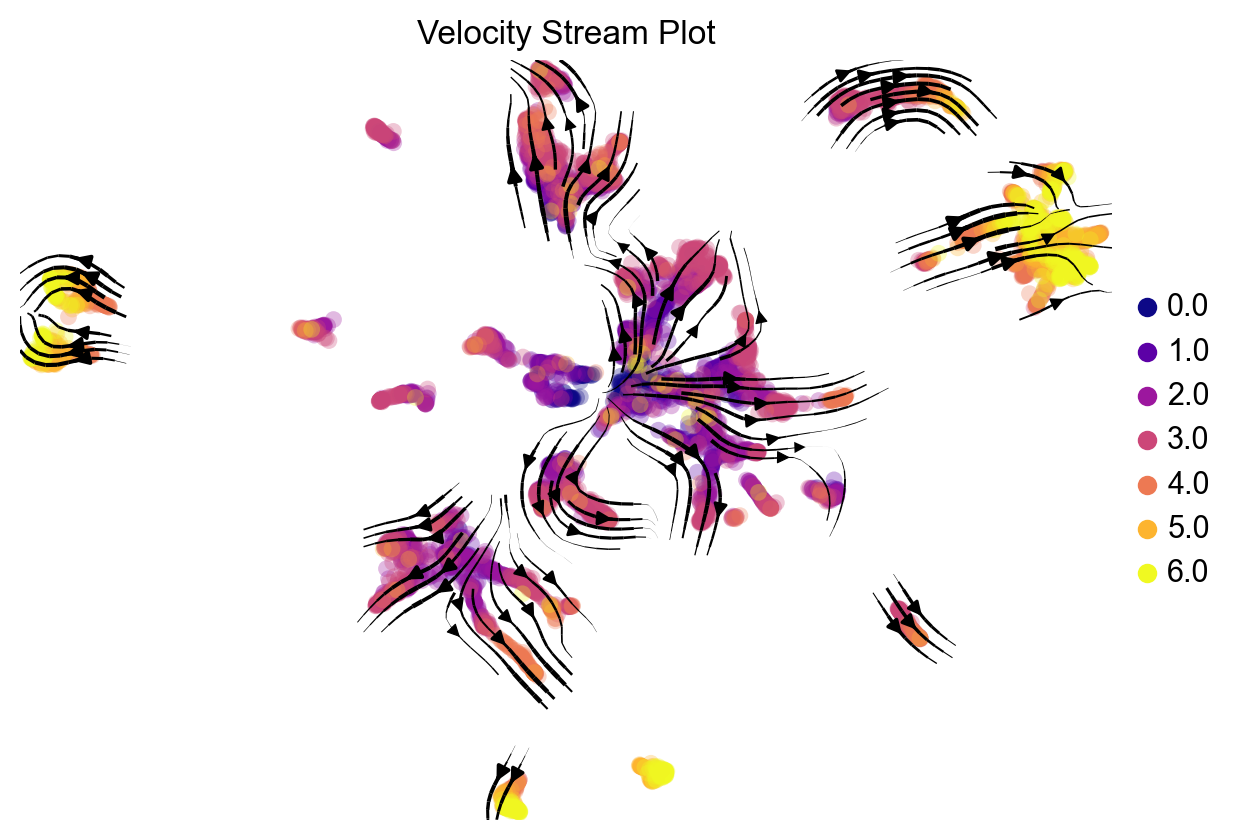

In [10]:
scv.pl.velocity_embedding_stream(
    adata,
    basis='umap',
    color='time_categorical',
    figsize=(7, 5),
    density=3,
    title='Velocity Stream Plot',
    legend_loc='right',
    palette='plasma',
)

### Plot score

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume the following are defined:
# - df: DataFrame with columns 'samples', 'x1', 'x2', ..., 'xn'
# - dim: Number of dimensions (n)
# - device: torch.device (e.g., 'cpu' or 'cpu')
# - sf2m_score_model: Your model function that takes t_tensor and data_tensor

# Step 1: Extract all time points and data points


all_times = df['samples'].values
all_data = df[[f'x{i}' for i in range(1, dim + 1)]].values

# Step 2: Convert to PyTorch tensors
data_tensor = torch.tensor(all_data, dtype=torch.float32).to(device)
data_tensor.requires_grad_(True)  # Enable gradient tracking
t_tensor = torch.tensor(all_times, dtype=torch.float32).unsqueeze(1).to(device)

# Step 3: Compute log density values and gradients
log_density_values = sf2m_score_model(t_tensor, data_tensor)
log_density_values.backward(torch.ones_like(log_density_values))
gradients = data_tensor.grad

# Step 4: Move data to CPU for plotting
data_np = data_tensor.detach().cpu().numpy()
if dim_reducer is not None:
    data_np_2d=dim_reducer.transform(data_np)
else:
    data_np_2d=data_np[:,:2]
gradients_np = gradients.detach().cpu().numpy()
data_end = data_np + gradients_np
if dim_reducer is not None:
    data_end_2d=dim_reducer.transform(data_end)
else:
    data_end_2d=data_end[:,:2]
gradients_np=data_end_2d - data_np_2d

gradients_np = gradients_np / np.linalg.norm(gradients_np, axis = 1, keepdims=True) * 5
times_np = all_times
data_np = data_np_2d

In [12]:
import anndata
import scvelo as scv
import scanpy as sc
import numpy as np

# Assume your data is already defined
# all_data: 50-dimensional data with shape (n_cells, 50)  
# gradients: 50-dimensional vector field with shape (n_cells, 50)
# pca: Trained PCA or UMAP model for generating X_umap
# X_umap: Pre-computed UMAP embeddings with shape (n_cells, 2)

# Create AnnData object
adata = anndata.AnnData(X=all_data)

# Set 'Ms' layer to avoid KeyError: 'Ms'
adata.layers['Ms'] = all_data  # Use original 50D data as state matrix
# Optional: normalize and log transform (based on data needs)
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata.layers['Ms'] = adata.X.copy()

# Set velocity vectors
adata.layers['velocity'] = gradients.detach().cpu().numpy()  # Store velocity vectors in layers
print(adata.layers['velocity'].shape)  # Confirm shape

# Set pre-computed UMAP embeddings
if dim_reducer is not None:
    X_umap = dim_reducer.transform(all_data)  # Assume pca is trained dim reduction model
else:
    X_umap = all_data[:,:2]
adata.obsm['X_umap'] = X_umap
print(adata.obsm['X_umap'].shape)  # Confirm UMAP embedding shape
adata.obs['time'] = all_times
if adata.layers['velocity'].shape[1] != 2:
    # Compute neighbor graph (required for velocity graph)
    sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')  # Calculate neighbors based on high-dim data

    # Compute velocity graph
    scv.tl.velocity_graph(adata, vkey='velocity', n_jobs=16)  # Build velocity graph from high-dim velocity vectors

    # Project velocities to UMAP space
    scv.tl.velocity_embedding(adata, basis='umap', vkey='velocity')  # Project velocities to UMAP
else:
    adata.obsm['velocity_umap'] = adata.layers['velocity']

# Plot
adata.obs['time_categorical'] = pd.Categorical(adata.obs['time'])

# Visualization settings
scv.settings.set_figure_params('scvelo')  # Set scvelo plotting style

(2947, 3)
(2947, 2)
computing velocity graph (using 16/32 cores)


  0%|          | 0/2947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


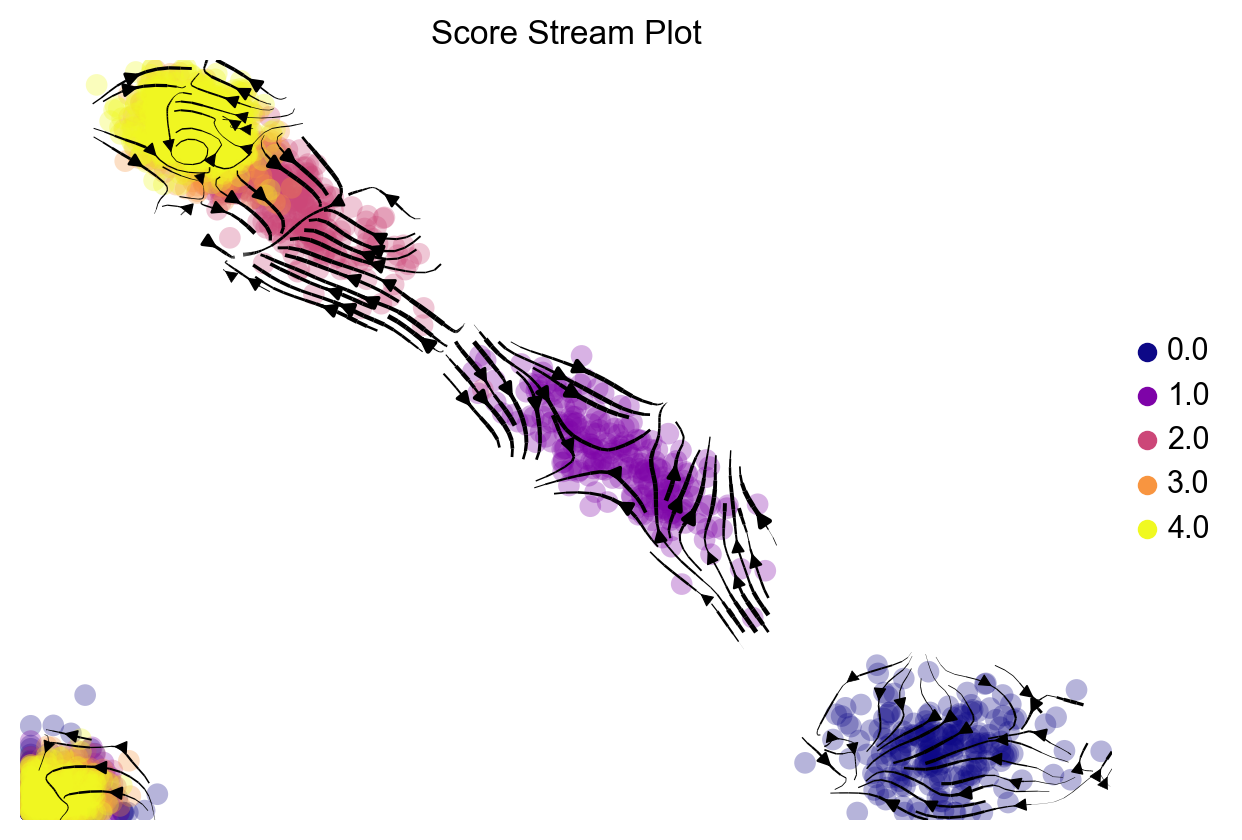

In [13]:
scv.pl.velocity_embedding_stream(
    adata,
    basis='umap',
    color='time_categorical',
    figsize=(7, 5),
    density=3,
    title='Score Stream Plot',
    legend_loc='right',
    palette='plasma',
)

### Plot drift

In [14]:
import numpy as np
import torch
device = 'cpu'
f_net.to(device)
sf2m_score_model.to(device)
# Assuming df, dim, device, f_net are defined
all_times = df['samples'].values
all_data = df[[f'x{i}' for i in range(1, dim + 1)]].values

# Convert to PyTorch tensors
t_tensor = torch.tensor(all_times, dtype=torch.float32).unsqueeze(1).to(device)
data_tensor = torch.tensor(all_data, dtype=torch.float32).to(device)

# Calculate gradients
with torch.no_grad():  # No need to track gradients to save memory
    gradients = f_net.v_net(t_tensor, data_tensor)

# Convert to NumPy array
gradients_np = gradients.cpu().numpy()


import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume the following are defined:
# - df: DataFrame with columns 'samples', 'x1', 'x2', ..., 'xn'
# - dim: Number of dimensions (n)
# - device: torch.device (e.g., 'cpu' or 'cpu')
# - sf2m_score_model: Your model function that takes t_tensor and data_tensor

# Step 1: Extract all time points and data points
all_times = df['samples'].values
all_data = df[[f'x{i}' for i in range(1, dim + 1)]].values

#t_value = 4.0  
#t_tensor = torch.tensor([t_value] * all_data.shape[0]).unsqueeze(1).float().to(device)
t_tensor = torch.tensor(all_times, dtype=torch.float32).unsqueeze(1).to(device)

# Step 2: Convert to PyTorch tensors
data_tensor = torch.tensor(all_data, dtype=torch.float32).to(device)
data_tensor.requires_grad_(True)  # Enable gradient tracking
#t_tensor = torch.tensor(all_times, dtype=torch.float32).unsqueeze(1).to(device)

# Step 3: Compute log density values and gradients
log_density_values = sf2m_score_model(t_tensor, data_tensor)
log_density_values.backward(torch.ones_like(log_density_values))
gradients_score = data_tensor.grad

In [15]:
overall=gradients_np+gradients_score.cpu().numpy()

In [16]:
import anndata
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
all_data = df[[f'x{i}' for i in range(1, dim + 1)]].values

# Assume data is defined: all_data, gradients, X_umap, all_times, cell_type
adata = anndata.AnnData(X=all_data)
adata.layers['Ms'] = all_data
adata.layers['velocity'] = overall
adata.obsm['X_umap'] = data_np
adata.obs['time'] = all_times
velocity_norm = adata.layers['velocity'] 
# Verify shapes
print("Velocity shape:", adata.layers['velocity'].shape)
print("UMAP shape:", adata.obsm['X_umap'].shape)

# Compute neighborhood graph
#sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')

# Compute velocity graph
#scv.tl.velocity_graph(adata, vkey='velocity', n_jobs=1)
#
# Handle velocity projection
if adata.layers['velocity'].shape[1] != 2:
    sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')
    scv.tl.velocity_graph(adata, vkey='velocity', n_jobs=16)
    scv.tl.velocity_embedding(adata, basis='umap', vkey='velocity')
else:
    adata.obsm['velocity_umap'] = adata.layers['velocity']

# Plot

adata.obs['time_categorical'] = pd.Categorical(adata.obs['time'])

Velocity shape: (2947, 3)
UMAP shape: (2947, 2)
computing velocity graph (using 16/32 cores)


  0%|          | 0/2947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


saving figure to file d:\DeepRUOTv2\results\simulation_data_tigon/all_velocity_stream_plot.svg


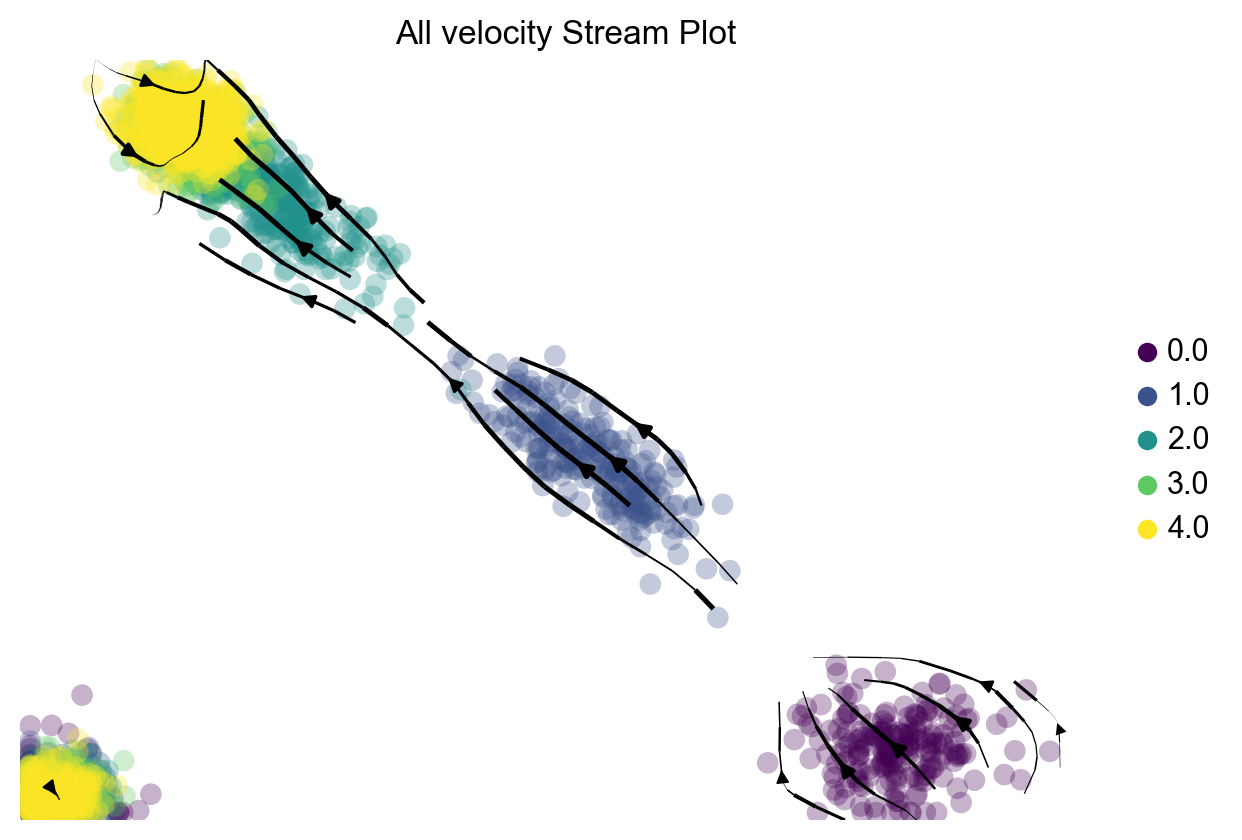

In [17]:
scv.settings.set_figure_params('scvelo')
scv.pl.velocity_embedding_stream(
    adata,
    basis='umap',
    color='time_categorical',
    figsize=(7, 5),
    density=1,
    title='All velocity Stream Plot',
    legend_loc='right',
    palette='viridis',
    save=exp_dir+'/all_velocity_stream_plot.svg'
)

### Generate trajectory

torch.Size([222, 50])
tensor([0., 1., 2., 3., 4., 5., 6.])
torch.Size([7, 222, 50])
torch.Size([7, 222, 1])
(7, 222, 2)


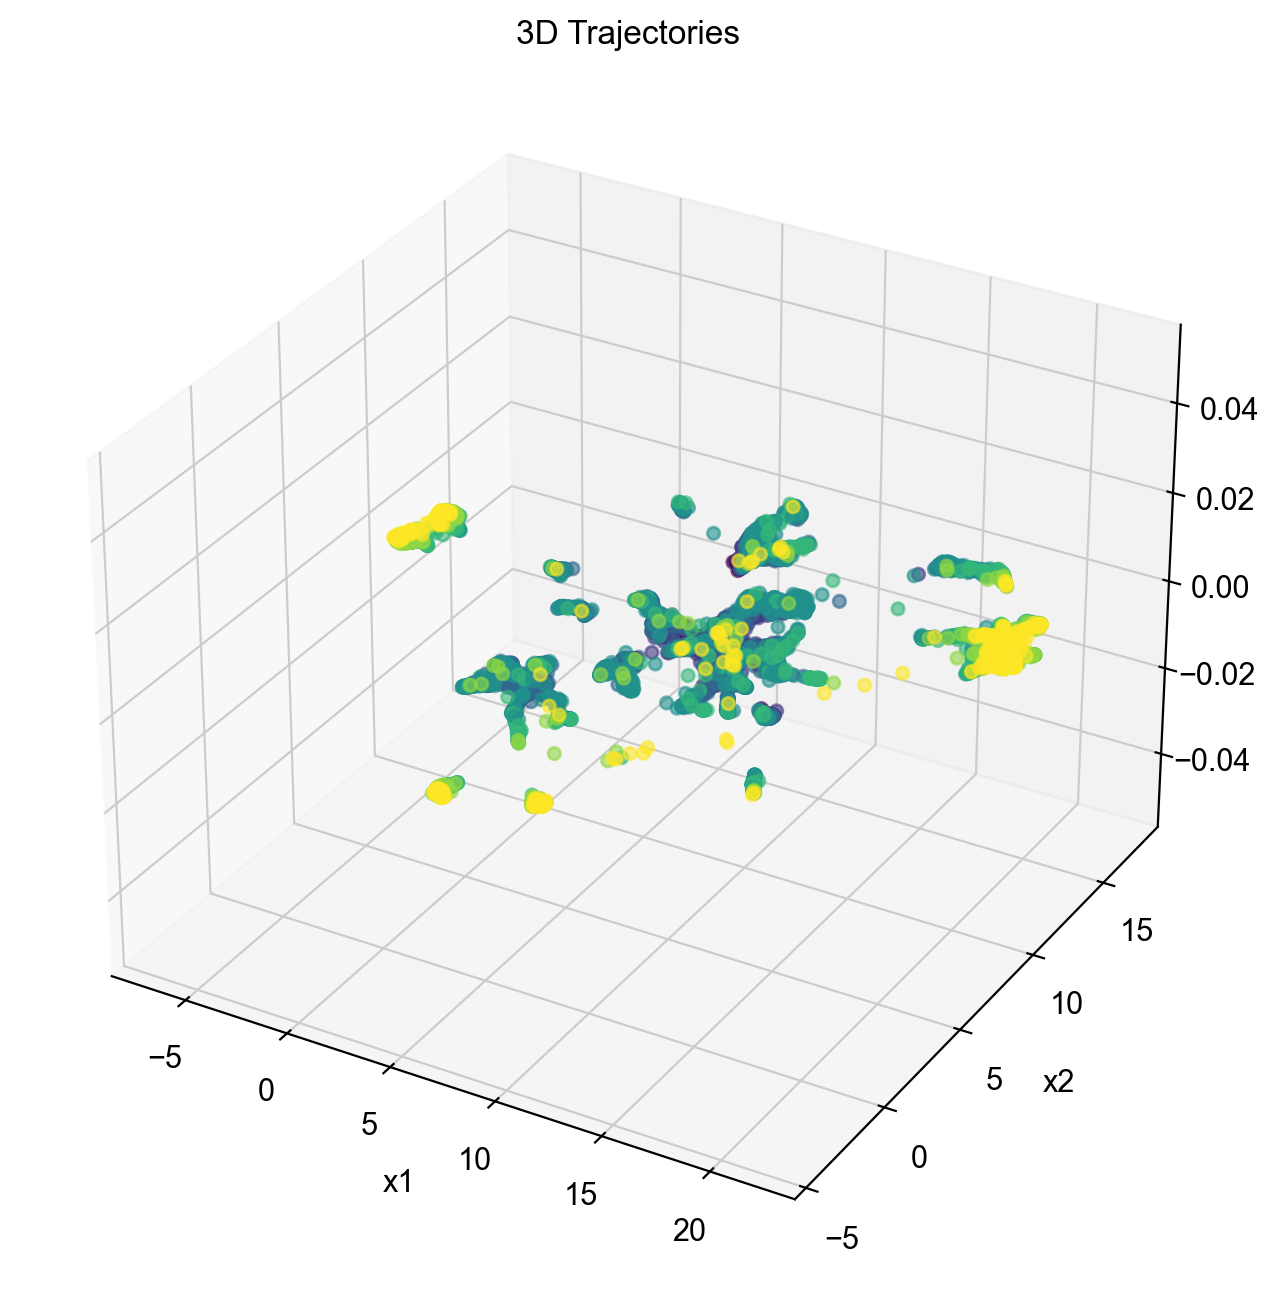

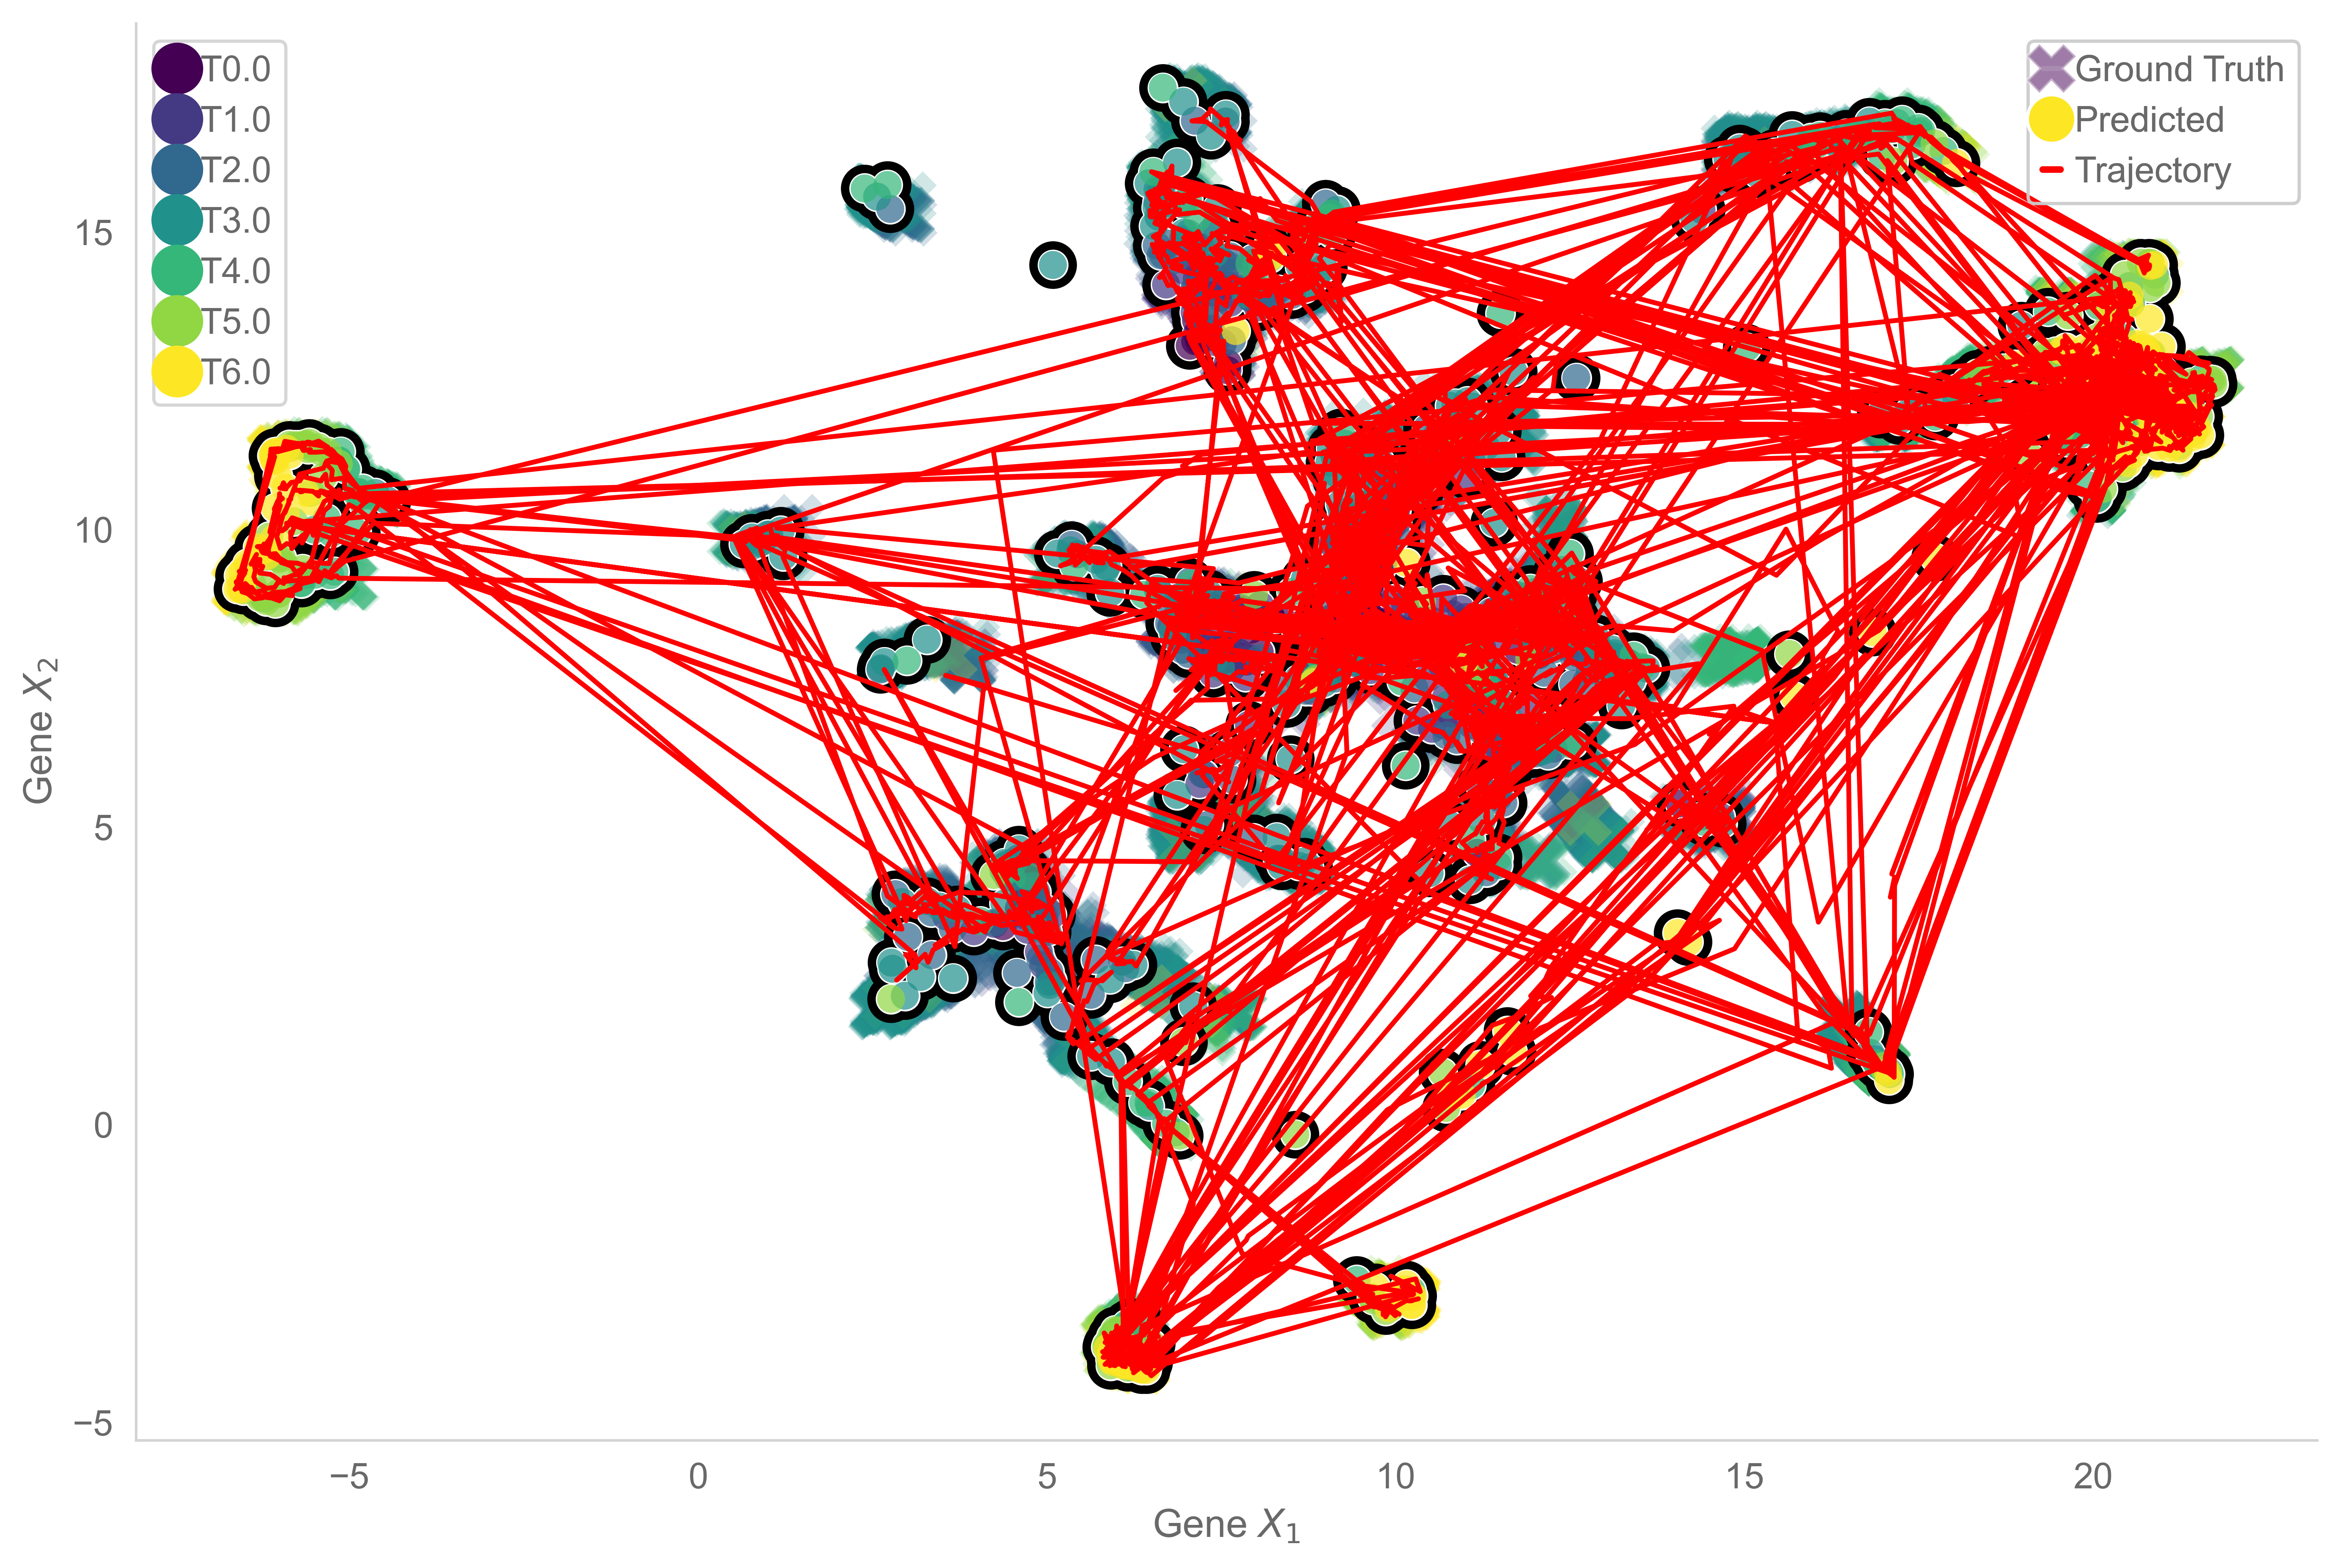

In [12]:
from DeepRUOT.utils import euler_sdeint
import random
n_times = all_times.max() + 1
data=torch.tensor(df[df['samples']==0].values,dtype=torch.float32).requires_grad_()
data_t0 = data[:, 1:].to(device).requires_grad_()
print(data_t0.shape)
x0=data_t0.to(device)

class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, g, score, input_size=(3, 32, 32), sigma=1.0):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.input_size = input_size
        self.sigma = sigma
        self.g_net = g

    # Drift
    def f(self, t, y):
        z, lnw = y
        drift=self.drift(t, z)
        dlnw = self.g_net(t, z)
        num = z.shape[0]
        t = t.expand(num, 1)  # Keep gradient information of t and expand its shape
        return (drift+self.score.compute_gradient(t, z), dlnw)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y)*self.sigma
    
x0_subset = x0.to(device)

x0_subset = x0_subset.to(device)
lnw0 = torch.log(torch.ones(x0_subset.shape[0], 1) / x0_subset.shape[0]).to(device)
initial_state = (x0_subset, lnw0)

# Define SDE object
sde = SDE(f_net.v_net, 
          f_net.g_net, 
          sf2m_score_model, 
          input_size=(2,), 
          sigma=config['score_train']['sigma'])

# Define time points, assuming total 200 integration steps
ts = torch.linspace(0, n_times - 1, 100, device=device)

# Manual SDE integration
sde_traj, traj_lnw = euler_sdeint(sde, initial_state, dt=0.1, ts=ts)
# Transfer to CPU if needed:
sde_traj, traj_lnw = sde_traj.cpu(), traj_lnw.cpu()


sample_number = 100  # For example, sample 10
sample_indices = random.sample(range(sde_traj.size(1)), sample_number)
sampled_sde_trajec = sde_traj[:, sample_indices, :]
sampled_sde_trajec.shape
sampled_sde_trajec = sampled_sde_trajec.tolist()
sampled_sde_trajec = np.array(sampled_sde_trajec, dtype=object)
np.save(exp_dir+'/sde_trajec.npy', sampled_sde_trajec)


ts_points = torch.tensor(sorted(df.samples.unique()), dtype=torch.float32)
print(ts_points)

sde_point, traj_lnw = euler_sdeint(sde, initial_state, dt=0.1, ts=ts_points)
print(sde_point.shape)
print(traj_lnw.shape)
weight = torch.exp(traj_lnw)
weight_normed = weight/weight.sum(dim = 1, keepdim = True)

sde_point_np = sde_point.detach().cpu().numpy()
sde_point_list = sde_point_np.tolist()
sde_point_array = np.array(sde_point_list, dtype=object)
np.save(exp_dir+'/sde_point.npy', sde_point_array)
np.save(exp_dir+'/sde_weight.npy', weight_normed.detach().cpu().numpy())

from DeepRUOT.plots import new_plot_comparisions2
sde_point = np.load(exp_dir+'/sde_point.npy', allow_pickle=True)
sde_point.shape

sde_trajec = np.load(exp_dir+'/sde_trajec.npy', allow_pickle=True)
samples = df.iloc[:, 0]  # Get samples column
features = df.iloc[:, 1:]  # Get feature columns

# Transform data based on whether dim_reducer is provided
if dim_reducer is not None:
    # Transform original data
    reduced_features = dim_reducer.transform(features)
    
    # Transform generated points
    generated_flattened = sde_point.reshape(-1, features.shape[1])
    generated_reduced = dim_reducer.transform(generated_flattened)
    generated_reduced = generated_reduced.reshape(sde_point.shape[0], -1, 2)
    
    # Transform trajectories 
    trajectories_flattened = sde_trajec.reshape(-1, features.shape[1])
    trajectories_reduced = dim_reducer.transform(trajectories_flattened)
    trajectories_reduced = trajectories_reduced.reshape(sde_trajec.shape[0], -1, 2)
else:
    # Use first two dimensions
    reduced_features = features.iloc[:,:3].values
    generated_reduced = sde_point[:,:,:3] 
    trajectories_reduced = sde_trajec[:,:,:3]

# Create dataframe with reduced dimensions
new_df = pd.DataFrame(reduced_features, columns=['x1', 'x2'])
new_df['samples'] = samples

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original data points
unique_times = sorted(df.samples.unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_times)))

for t, color in zip(unique_times, colors):
    mask = new_df['samples'] == t
    ax.scatter(new_df[mask]['x1'], 
              new_df[mask]['x2'],
              c=[color], alpha=0.6, label=f't={t}')

# Plot generated points
print(generated_reduced.shape)
for t_idx, t in enumerate(unique_times):
    # Check if generated_reduced[t_idx] is a float
    if isinstance(generated_reduced[t_idx], float):
        print(f"Warning: generated_reduced[{t_idx}] is a float value")
        continue
        
    try:
        ax.scatter(generated_reduced[t_idx][:,0],
                  generated_reduced[t_idx][:,1], 
                  c = [colors[t_idx]], alpha=0.6)
    except AttributeError as e:
        print(f"Error plotting time {t}: {e}")
        print(f"Shape of generated_reduced[{t_idx}]: {generated_reduced[t_idx].shape if hasattr(generated_reduced[t_idx], 'shape') else type(generated_reduced[t_idx])}")

# # Plot trajectories  
# for traj in trajectories_reduced:
#     ax.plot(traj[:,0], traj[:,1], traj[:,2],
#             c='gray', alpha=0.2, linewidth=1)

ax.set_xlabel('x1')
ax.set_ylabel('x2') 
plt.title('3D Trajectories')
#plt.savefig(os.path.join(exp_dir, '3d_trajectories.pdf'))
plt.show()


new_plot_comparisions2(
    new_df, generated_reduced, trajectories_reduced,
    palette='viridis', df_time_key='samples', 
    save=True, path=exp_dir, file='sde_trajectories.pdf',
    x='x1', y='x2', z='x3', is_3d=True
)